# Plane Wave Enhancement using Kruer's Resonance Absorption

In [32]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, minimize
from scipy.special import lambertw

## Functions
- See: https://ronak-n-desai.github.io/25spr2/

In [39]:
c = 3e8
w0=1.87e-6/np.sqrt(2*np.log(2))
lmbda = 0.78e-6 #1.053e-6
omega = 2*np.pi*c/lmbda
def efield(theta, x, case=1):
    norm_omega = omega * x / c
    sign = 1 if case == 1 else -1
    prefactor = norm_omega**(1/3) # (1/norm_omega**(1/6)) or 1
    return prefactor * np.sin(theta) * np.exp(-2/3 * norm_omega * np.sin(theta)**3)

def critical_points(theta1, theta2, alpha = 1, case=1): 
    log_factor = np.log(np.sqrt(2) * alpha - 1)
    A = np.log(np.sin(theta1) / np.sin(theta2))
    B = (np.sin(theta1)**3 - np.sin(theta2)**3)
    p1 = (3/2) * c / omega * (A + log_factor) / B
    p2 = (3/2) * c / omega * (A - log_factor) / B
    return np.array([p1, p2])

def length_scale(theta1, theta2, alpha=1, case=1):
    c = 3e8
    lmbda = 1.053e-6
    omega = 2*np.pi*c/lmbda
    A = np.log(np.sin(theta1) / np.sin(theta2))
    B = (np.sin(theta1)**3 - np.sin(theta2)**3)
    log_factor = np.log(np.sqrt(2) * alpha - 1)
    if case == 1:
        return (3/2) * c / omega * (A - log_factor) / (B)
    elif case == 2:
        return (3/2) * c / omega * (A + log_factor) / (B)
    
def efs(x, y, theta):
    return np.exp(-(x**2 * np.sin(theta)**2 + y**2 * np.cos(theta)**2 + 2*x*y*np.sin(theta)*np.cos(theta))/w0**2)

## Plot Max Enhancement and Electric Fields
Using $E(\tau) \propto \phi(\tau) = \tau \exp(-2 \tau^3/3)$, the maximum electric field satisfies $\tau = (0.5)^{1/3}$. Since $\tau^3 \equiv \frac{\omega L}{c} \sin^3(\theta)$, this makes

\begin{equation}
    \theta_\text{opt} = 0.8 (\frac{c}{\omega L})^{1/3}
\end{equation}

or 

\begin{equation}
    L_\text{opt} = \frac{c}{2 \omega \sin^3(\theta)} = \frac{\lambda}{4 \pi \sin^3 \theta}
\end{equation}

the enhancement regions are defined by $x_\mp$

\begin{equation}
    x_\mp = \frac{3 c}{2 \omega (\sin^3 \theta_1 - \sin^3 \theta_2)} [\log \left(\frac{\sin \theta_1}{\sin \theta_2} \right) \pm \log(\sqrt{2} \alpha -1)]
\end{equation}

This can be derived by considering the enhancement $\alpha$ as 

\begin{equation}
    \alpha = \frac{\phi_1(\tau_1) + \phi_2(\tau_2)}{\sqrt{2} \phi_1(\tau)}
\end{equation}

and solving for $L$ (where only $\theta$ is changing in $\tau$). 

1.0004560390039121 0.2823669028804596


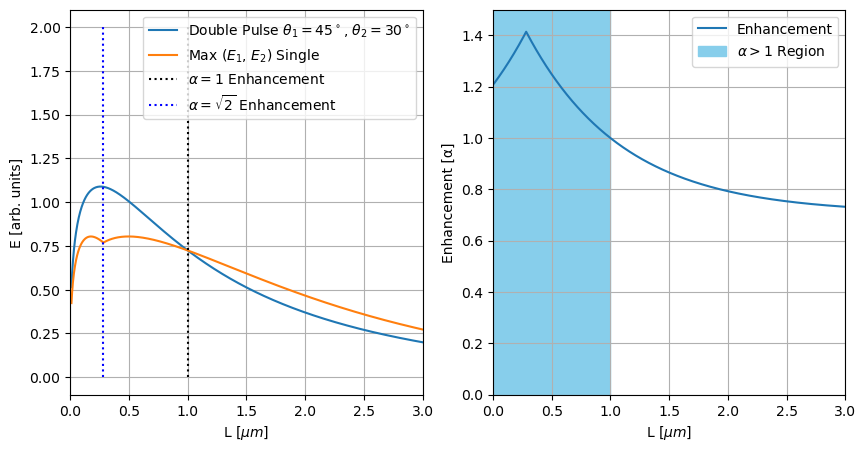

In [54]:
# Choose two angles (theta1 > theta2)
theta1 = 45
theta2 = 30
x_end = 3e-6
xs = np.linspace(0.01e-6, x_end, 1000)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
efield1 = efield(np.deg2rad(theta1), xs)
efield2 = efield(np.deg2rad(theta2), xs, case=2)
efield_max = np.maximum(efield1, efield2)*np.sqrt(2)
efield_tot = efield1 + efield2
ax[0].plot(xs*1e6, efield_tot, label=f"Double Pulse $θ_1 = {theta1}^\circ$, $θ_2 = {theta2}^\circ$")
ax[0].plot(xs*1e6, efield_max, label=f"Max ($E_1$, $E_2$) Single")
ax[1].plot(xs*1e6, efield_tot/efield_max, label=f"Enhancement")
points = critical_points(np.deg2rad(theta1), np.deg2rad(theta2))*1e6
point = critical_points(np.deg2rad(theta1), np.deg2rad(theta2), alpha=np.sqrt(2))*1e6
print(points[1], point[0])
ax[0].vlines([points[1], points[0]], 0, 2, linestyle='dotted', color='black', label='$α = 1$ Enhancement')
ax[0].vlines([point[0]], 0, 2, linestyle='dotted', color='blue', label='$α = \sqrt{2}$ Enhancement')
ax[1].fill_between([points[1],points[0]], 0, 2, color='skyblue', hatch='//', label="$α > 1$ Region")
ax[0].set_ylabel("E [arb. units]")
ax[1].set_ylim(0, 1.5)
ax[1].set_ylabel("Enhancement [α]")
for i in range(2):
    ax[i].set_xlabel("L [$\mu m$]")
    ax[i].set_xlim(0, x_end*1e6)
    ax[i].legend()
    ax[i].grid(True)

## Electric Field with Varying Angles
Fixing $\theta_2$, which values of $\theta_1$ optimize the peak electric fields?

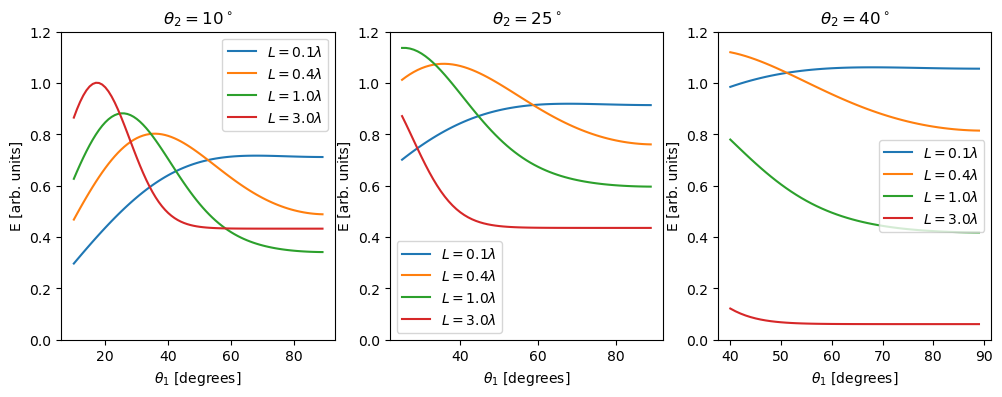

In [30]:
factors = np.array([.1, .4, 1, 3])
xs = factors * lmbda
fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
for j, theta2 in enumerate([10, 25, 40]):
    theta1s = np.arange(theta2, 90, 1)
    for i, x in enumerate(xs):
        efield1 = efield(np.deg2rad(theta1s), x)
        efield2 = efield(np.deg2rad(np.ones_like(theta1s) * theta2), x)
        efield_max = np.maximum(efield1, efield2)*np.sqrt(2)
        efield_tot = efield1 + efield2
        ax[j].plot(theta1s, efield_tot, label=f"$L = {factors[i]}\lambda$")
    ax[j].set_xlabel("$θ_1$ [degrees]")
    ax[j].set_ylabel("E [arb. units]")
    ax[j].legend()
    ax[j].set_title(f"$θ_2 = {theta2}^\circ$")
    ax[j].set_ylim(0, 1.2)

## Enhancement Region for fixed angle differences

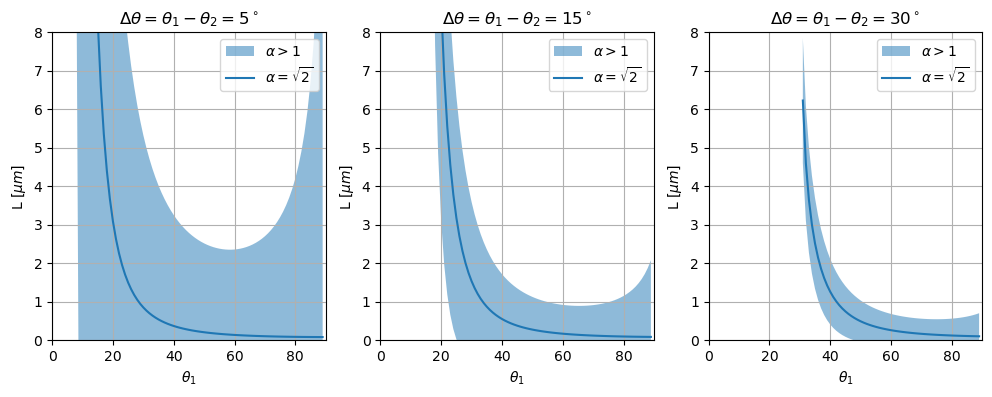

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i, dtheta in enumerate([5, 15, 30]):
    theta1s = np.arange(dtheta + 1, 90, 1)
    theta2s = theta1s - dtheta
    ls = length_scale(np.deg2rad(theta1s), np.deg2rad(theta2s), case=1)
    ls2 = length_scale(np.deg2rad(theta1s), np.deg2rad(theta2s), case=2)
    ls_opt = length_scale(np.deg2rad(theta1s), np.deg2rad(theta2s), case=1, alpha=np.sqrt(2))
    
    ax[i].fill_between(theta1s, ls*1e6, ls2*1e6, alpha=0.5, label='$α > 1$')
    ax[i].plot(theta1s, ls_opt*1e6, label="$α = \sqrt{2}$")
    ax[i].set_xlabel(r"$\theta_1$")
    ax[i].set_ylabel(r"L [$\mu m$]")
    ax[i].set_ylim(0, 8)
    ax[i].set_title(f"$\Delta θ = θ_1 - θ_2 = {dtheta}^\circ$")
    ax[i].set_xlim(0, 90)
    ax[i].grid(True)
    ax[i].legend()

## Electric Field for various scale lengths and angles

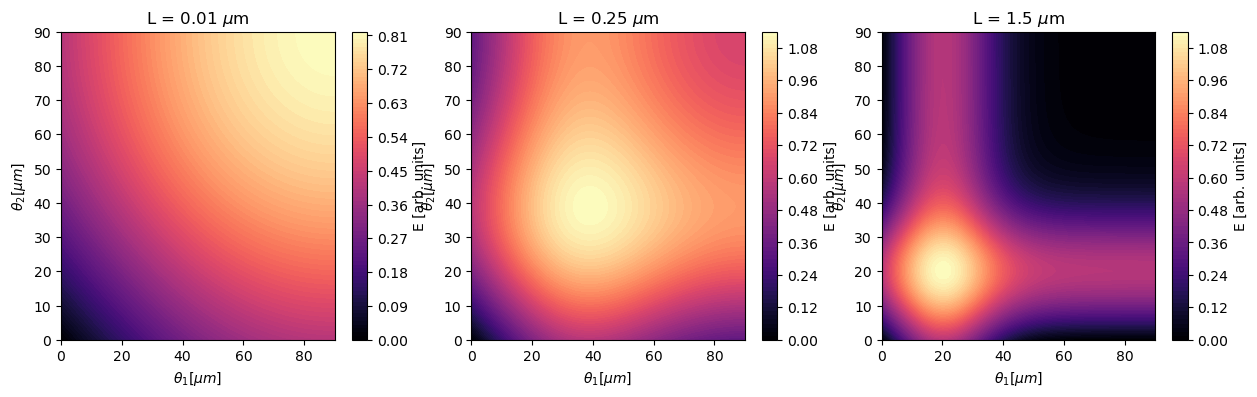

In [47]:
scale_lengths = [0.01, 0.25, 1.5]
theta1s = np.linspace(0, np.pi/2, 100)
theta2s = np.linspace(0, np.pi/2, 100)
XX, YY = np.meshgrid(theta1s, theta2s)

fig, ax = plt.subplots(ncols = 3, figsize=(15, 4))
for i in range(3):
    ef = efield(XX, scale_lengths[i]*1e-6) + efield(YY, scale_lengths[i]*1e-6, case=2)
    cax = ax[i].contourf(np.rad2deg(XX), np.rad2deg(YY), ef, levels=100, cmap = 'magma')
    cbar = fig.colorbar(cax)
    cbar.set_label("E [arb. units]")
    ax[i].set_xlabel(r"$θ_1 [\mu m]$")
    ax[i].set_ylabel(r"$θ_2 [\mu m]$")
    ax[i].set_title(f"L = {scale_lengths[i]} $\mu$m")
